In [1]:
!pip install pillow
!pip install split-folders
!pip install wandb -qqq
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback

import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import SGD

     |████████████████████████████████| 2.1MB 12.9MB/s 
     |████████████████████████████████| 163kB 62.2MB/s 
     |████████████████████████████████| 133kB 62.0MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 25 12:53:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
#Parameters
batch_size = 156
size=(224, 224)
num_classes = 196
input_tensor = (224, 224, 3)
dropout_rate=0.2
epochs=20
lr=1e-2
TL=True
split=(0.8, 0.1, 0.1)
data_dir='/content/output/'

In [30]:
wandb.login()
run = wandb.init(project='Deep Learning Assignment',
                 config={  
                     "learning_rate": lr,
                     "epochs": epochs,
                     "batch_size": batch_size,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "EfficientNetB0",
                     "dataset": "Stanford Cars",
                     "optimizer":"SGD",
                     "Split": split,
                     "Transfer Learning": TL
                 })

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1502, in _atexit_cleanup
    self._on_finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1659, in _on_finish
    self._backend.interface.publish_telemetry(self._telemetry_obj)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 231, in publish_telemetry
    self._publish(rec)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 524, in _publish
    raise Exception("The wandb backend process has shutdown")
Exception: The wandb backend process has shutdown


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
!wget http://drive.genos-drive.workers.dev/allimages.zip
!mkdir cars
!unzip -qq allimages.zip -d /content/cars

splitfolders.ratio('cars', output="output", ratio=split) 

--2021-04-25 12:55:30--  http://drive.genos-drive.workers.dev/allimages.zip
Resolving drive.genos-drive.workers.dev (drive.genos-drive.workers.dev)... 104.21.234.167, 104.21.234.166, 2606:4700:3038::6815:eaa7, ...
Connecting to drive.genos-drive.workers.dev (drive.genos-drive.workers.dev)|104.21.234.167|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021717089 (974M) [application/zip]
Saving to: ‘allimages.zip’

allimages.zip       100%[===================>] 974.38M   101MB/s    in 11s     

2021-04-25 12:55:42 (85.9 MB/s) - ‘allimages.zip’ saved [1021717089/1021717089]



Copying files: 16185 files [00:04, 3349.29 files/s]


In [34]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255.)
    ]
)
def load_dataset(dir, train):
  dataset = keras.preprocessing.image_dataset_from_directory(
        dir,  
        image_size=size, 
        batch_size=batch_size,
        labels="inferred",
        seed=1337,
        label_mode="categorical",
        color_mode="rgb",
        shuffle=True)
  dataset=dataset.map(lambda x, y: (data_augmentation(x, training=train), y))
  return dataset.prefetch(buffer_size=batch_size)


In [35]:
train_generator = load_dataset(data_dir+'train', True)
validation_generator = load_dataset(data_dir+'val', False)
test_generator = load_dataset(data_dir+'test', False)

Found 12873 files belonging to 196 classes.
Found 1524 files belonging to 196 classes.
Found 1788 files belonging to 196 classes.


In [36]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [37]:
inputs = tf.keras.layers.Input(shape=input_tensor)
x = img_augmentation(inputs)
model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)
model = Model(inputs, outputs, name="EfficientNetB0")

model.compile(optimizer=SGD(lr=lr, momentum=0.9), loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [38]:
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5), ##EfficientNetB0 ends early without training
    tf.keras.callbacks.ModelCheckpoint(filepath='modelcheckpoint/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.0001),
    WandbCallback()
]

In [40]:
history=model.fit(train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=my_callbacks)

Epoch 1/25
83/83 [==============================] - 65s 735ms/step - loss: 0.9573 - categorical_accuracy: 0.7480 - val_loss: 6.0449 - val_categorical_accuracy: 0.0361
Epoch 2/25
83/83 [==============================] - 64s 724ms/step - loss: 0.8893 - categorical_accuracy: 0.7637 - val_loss: 4.8161 - val_categorical_accuracy: 0.1214
Epoch 3/25
83/83 [==============================] - 64s 721ms/step - loss: 0.8071 - categorical_accuracy: 0.7854 - val_loss: 5.5404 - val_categorical_accuracy: 0.0689
Epoch 4/25
83/83 [==============================] - 63s 714ms/step - loss: 0.7611 - categorical_accuracy: 0.7963 - val_loss: 4.4080 - val_categorical_accuracy: 0.1608
Epoch 5/25
83/83 [==============================] - 62s 704ms/step - loss: 0.6930 - categorical_accuracy: 0.8194 - val_loss: 4.3241 - val_categorical_accuracy: 0.1588
Epoch 6/25
83/83 [==============================] - 63s 711ms/step - loss: 0.6468 - categorical_accuracy: 0.8265 - val_loss: 6.0873 - val_categorical_accuracy: 0.042

In [41]:
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
12/12 [==============================] - 9s 242ms/step - loss: 1.6065 - categorical_accuracy: 0.5917
test loss, test acc: [1.6064780950546265, 0.5917226076126099]


In [44]:
modeltest = keras.models.load_model('/content/modelcheckpoint/model.24-0.88.h5')
results = modeltest.evaluate(test_generator)
print("test loss, test acc:", results)

12/12 [==============================] - 8s 182ms/step - loss: 0.8547 - categorical_accuracy: 0.7685
test loss, test acc: [0.8547494411468506, 0.7684563994407654]


In [ ]:
!zip -r my_model.zip modelcheckpoint/ wandb/ logs/
!cp my_model.zip "/content/drive/Shareddrives/Untitled shared drive/my_model_EfficientNetB0.zip"

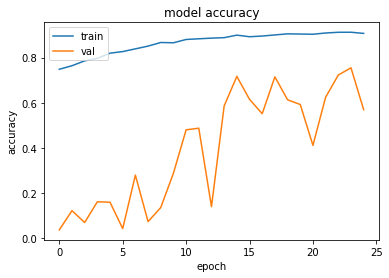

In [45]:
from matplotlib import pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

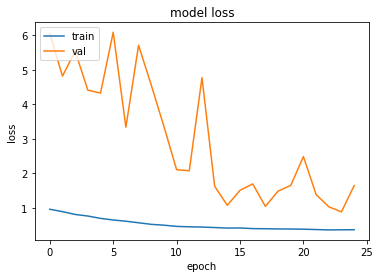

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()